In [6]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import functions as f 

Select the file for checking 

In [7]:
PATH = 'realKnownCause/rogue_agent_key_hold.csv'
ERRORPATH = 'labels/combined_windows.json'

In [8]:
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

In [9]:
# Convert error windows to datetime
error_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in df_error]

# Raw data
## Mark outliers

In [5]:
# Mark outliers
def is_outlier(timestamp, error_windows):
    for start, end in error_windows:
        if start <= timestamp <= end:
            return 1
    return 0

df['outlier'] = df['timestamp'].apply(lambda x: is_outlier(x, error_windows))


## Check percentage of the outliers against the dataset

In [6]:
# Count the occurrences of each outlier value
counts = df['outlier'].value_counts()

# Calculate the ratio
ratio = counts.get(1, 0) / counts.get(0, 1)  # Use default 0 for missing values
print("Ratio of outliers to non-outliers:", ratio)

Ratio of outliers to non-outliers: 0.11229314420803782


## Visualise data and outliers

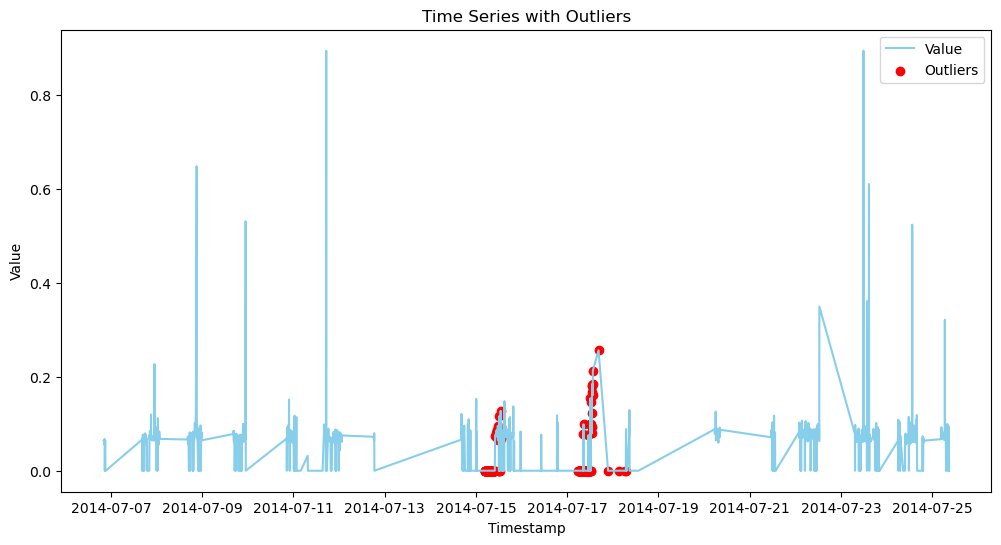

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.scatter(df['timestamp'][df['outlier'] == 1], df['value'][df['outlier'] == 1], color='red', label='Outliers')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


## Distribution of values

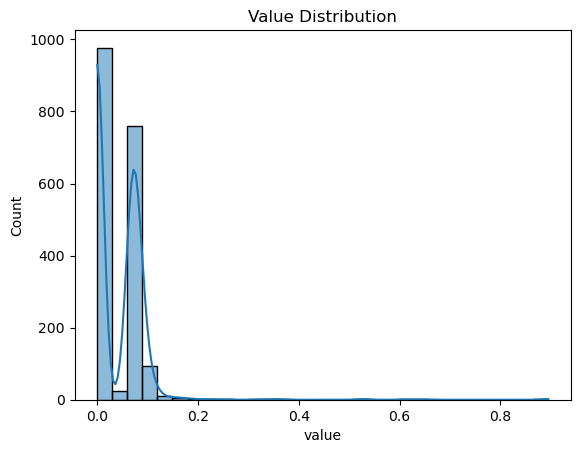

In [8]:
import seaborn as sns

# Plot value distribution
sns.histplot(df['value'], bins=30, kde=True)
plt.title('Value Distribution')
plt.show()


Pandas also provide a function to define the skewness of data. Refer to define_skewness in function.py

In [17]:
df.value.skew()

5.9547484049367885

With skew value is a positive number, this indicates the distribution is right-skewed, or the tail of the distribution is more pronounced on the right.

## Time gaps

timestamp
0 days 00:05:00    1790
0 days 00:10:00      47
0 days 00:20:00       8
0 days 00:35:00       6
0 days 00:30:00       2
0 days 00:15:00       2
0 days 00:25:00       2
0 days 14:40:00       1
0 days 00:40:00       1
0 days 19:00:00       1
0 days 16:30:00       1
0 days 21:10:00       1
0 days 03:40:00       1
0 days 00:50:00       1
0 days 16:40:00       1
1 days 21:35:00       1
0 days 03:00:00       1
0 days 05:00:00       1
0 days 06:00:00       1
0 days 03:10:00       1
0 days 01:10:00       1
0 days 00:55:00       1
1 days 16:05:00       1
1 days 02:45:00       1
0 days 12:20:00       1
0 days 18:40:00       1
0 days 01:15:00       1
0 days 09:35:00       1
0 days 01:25:00       1
0 days 02:30:00       1
0 days 08:40:00       1
Name: count, dtype: int64


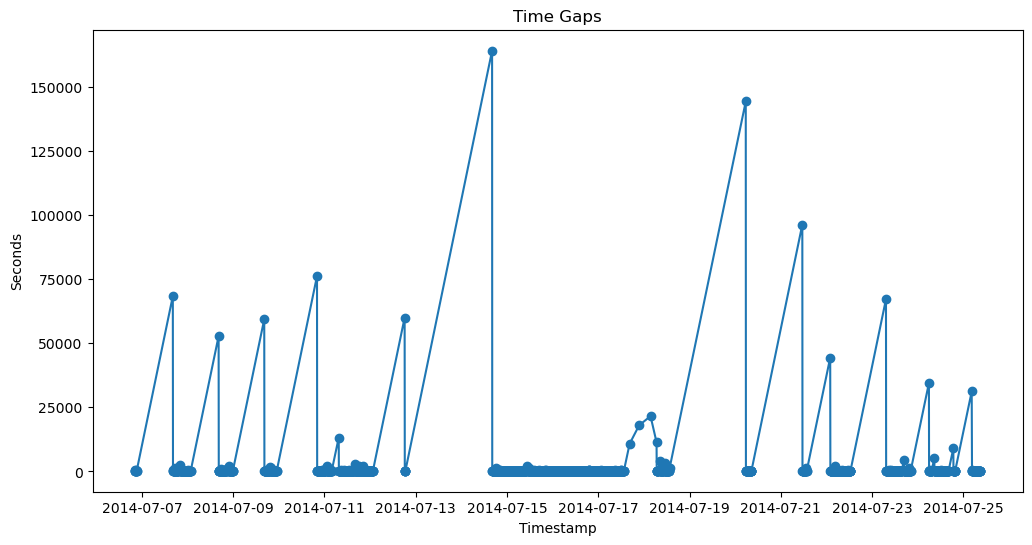

In [9]:
# Calculate time differences between consecutive timestamps
time_diff = df['timestamp'].diff()
print(time_diff.value_counts())

# Visualize time gaps
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], time_diff.dt.total_seconds(), marker='o')
plt.title('Time Gaps')
plt.ylabel('Seconds')
plt.xlabel('Timestamp')
plt.show()


Timegaps are not equal.

There is also a day gap (-1 day). This indicates the dataset is not sorted properly. 

Furthermore, below there are some time-mark that contains duplicates:

In [108]:
# Identify duplicates
duplicates = df.duplicated('timestamp', keep=False)

# Print duplicates
print('Duplicates are:')
print(df[duplicates])

Duplicates are:
                timestamp      value  outlier
10137 2014-01-07 02:00:00  94.423406        0
10138 2014-01-07 02:05:00  94.698730        0
10139 2014-01-07 02:10:00  95.332824        0
10140 2014-01-07 02:15:00  95.079199        0
10141 2014-01-07 02:20:00  94.881208        0
10142 2014-01-07 02:25:00  94.563961        0
10143 2014-01-07 02:30:00  93.430922        0
10144 2014-01-07 02:35:00  93.729663        0
10145 2014-01-07 02:40:00  93.192987        0
10146 2014-01-07 02:45:00  93.967871        0
10147 2014-01-07 02:50:00  93.397374        0
10148 2014-01-07 02:55:00  92.855999        0
10149 2014-01-07 02:00:00  94.139723        0
10150 2014-01-07 02:05:00  94.111970        0
10151 2014-01-07 02:10:00  94.638723        0
10152 2014-01-07 02:15:00  93.270907        0
10153 2014-01-07 02:20:00  93.890249        0
10154 2014-01-07 02:25:00  93.396627        0
10155 2014-01-07 02:30:00  94.199300        0
10156 2014-01-07 02:35:00  94.125420        0
10157 2014-01-07 0

To avoid this problem, propose function process_time_series. Redo the whole process.

In this new process, 
* data must be sorted first in an ascending order, meaning the timestamp must increase over time.
* define the most frequent interval in the dataset
* the dataset will be grouped based on the found interval

Refer to process_time_series function in functions.py

Furthermore, if there exists NA value after groupping, using linear interpolation to fill the NaN value. Linear interpolation is applied based on the assumption that data should change overtime. 
# New process - sort and group data, linear interpolation

In [10]:
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
# Apply process_time_series 
time_diff, df = f.process_time_series(df, grouping=True)
df['value_min'] = df['value_min'].interpolate(method='linear') 


with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

# Convert error windows to datetime
error_windows = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in df_error]

# Mark outliers
def is_outlier(timestamp, error_windows):
    for start, end in error_windows:
        if start <= timestamp <= end:
            return 1
    return 0

df['outlier'] = df['timestamp'].apply(lambda x: is_outlier(x, error_windows))


## Check the ratio of outliers

In [11]:
# Count the occurrences of each outlier value
counts = df['outlier'].value_counts()

# Calculate the ratio
ratio = counts.get(1, 0) / counts.get(0, 1)  # Use default 0 for missing values
print("Ratio of outliers to non-outliers:", ratio)

Ratio of outliers to non-outliers: 0.11229314420803782


## Visualise data and outliers

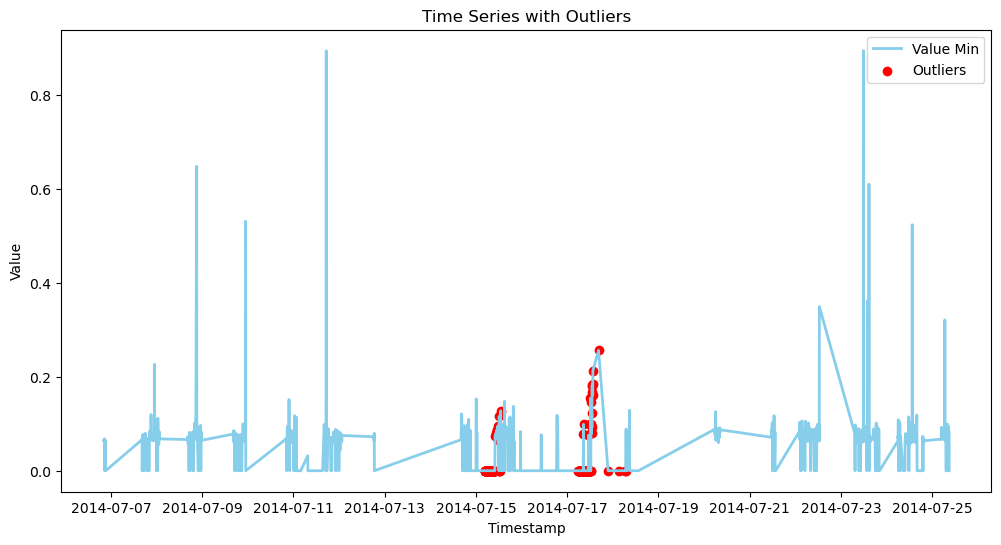

In [12]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value_min'], label='Value Min', color='skyblue', linewidth=2)
plt.scatter(df['timestamp'][df['outlier'] == 1], df['value_min'][df['outlier'] == 1], color='red', label='Outliers')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

Plot the distribution of the values

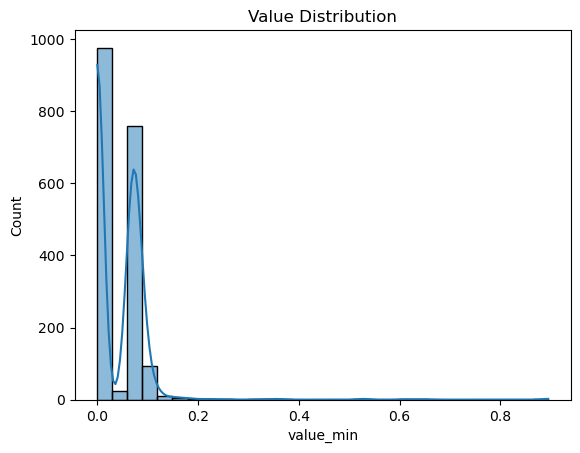

In [13]:
import seaborn as sns

# Plot value distribution
sns.histplot(df['value_min'], bins=30, kde=True)
plt.title('Value Distribution')
plt.show()

Similarly, pandas.skew() can be applied here:

In [14]:
print('Value skewness: ', df.value_min.skew())

Value skewness:  5.9547484049367885


## Define data period of daily and monthly (count of data)

Before finding the trend, seasonality, residual of the dataset, which can be found under this library: from statsmodels.tsa.seasonal import seasonal_decompose

period per day, week, month must be found. Period is the number of events within the defined timeframe. For example, if the interval is 300seconds, 1 day is calculated as:
$$period\_1\_day = \frac{24 hours \times 60 minutes \times 60 seconds}{300 seconds}$$
The function can be found under name period_pattern in functions.py

In [15]:
periods = f.period_pattern(df, time_diff)

In [16]:
keys, values = list(periods.keys()), list(periods.values())

## Seasonal decomposition

* The trend represents the long-term movement or direction in the data. It can be upward, downward, or flat. A trend reflects the gradual increase or decrease over time and is often influenced by factors like population growth, economic shifts, or technological advances.
* Seasonality refers to repeating patterns or cycles that occur at regular intervals within a year, month, week, or even day. These patterns are often driven by external factors such as seasons, holidays, or events.
* The residual is the leftover part of the time series that cannot be explained by the trend or seasonality. It represents random variations, noise, or outliers in the data. This component captures the unpredictable, irregular fluctuations that do not follow a systematic pattern.

Before that, it is good to know whether the data is additive or multiplicative. These terms describe the relationship between the components: trend, seasonality, and residual. At a given time t, additive is defined as:
$$ Y(t) = T(t) + S(t) + R(t) $$
Key Characteristics:

* Trend and seasonal variations are independent of the level of the time series.
* The size of the seasonal variation is constant over time.
* Example: Daily temperatures that fluctuate around a constant trend with similar highs and lows each year.
Multiplicative is defined as:
$$ Y(t) = T(t) * S(t) * R(t) $$
Alternatively, taking logs in 2 sides:
$$ logY(t) = logT(t) + logS(t) + logR(t) $$
Key Characteristics:

* Seasonal variations depend on the level of the time series.
* The size of the seasonal variation increases or decreases proportionally with the trend.
* Example: Retail sales where seasonal spikes (e.g., holidays) grow as the overall trend increases over time.

To automate this process:
* Check variance and rolling correlation.
* Apply a log transformation and assess variance stability.
* Perform decomposition and check seasonal proportionality.
* Compare additive and multiplicative models using error metrics.

Furthermore: 
* Correlation between 0.5 - 0.7 suggests moderately correlated (https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm#:~:text=Correlation%20coefficients%20whose%20magnitude%20are%20between%200.5%20and%200.7%20indicate,can%20be%20considered%20moderately%20correlated.)
* To determine the threshold of variance reduction, either applying KNN with Elbow to find the number of cluster where adding more cluster does not add more knowlege to the prediction (elbow) or Sillouette method in which a higher silhouette score indicates that clusters are well-defined and separated.
* Compare the Exponential Smoothing using RSME, select one with lower score.

Refer to function Define multiplicative or additive functions in functions.py

In [17]:
periods

{3: 900, 6: 1800, 9: 2700, 288: 86400}

In [18]:
add_or_mul = f.add_or_mul(df.copy(), periods, 'value_min')
add_or_mul

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


['Multiplicative', 'Additive', 'Additive', 'Multiplicative']

Plugging the additive or multiplicative to the seasonal_decompose.

Adding try and except to escape the case if there is not enough data

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

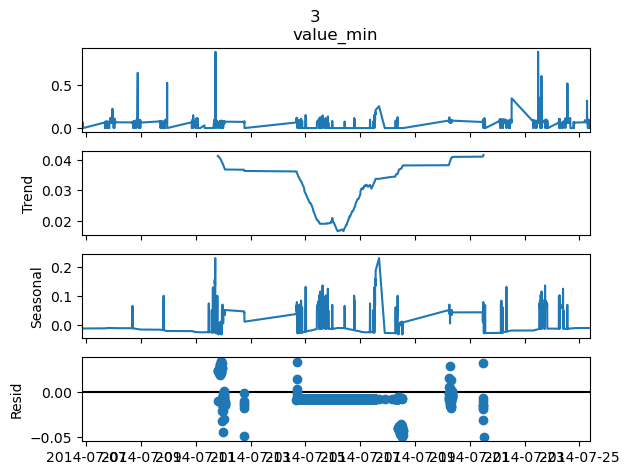

In [20]:
for i in range(len(periods)):
    try:
        decomposition = seasonal_decompose(df.set_index('timestamp')['value_min'], model=add_or_mul[i],
                                       period=values[i])  # Adjust period
    except:
        continue
    fig = decomposition.plot()
    fig.suptitle(keys[i])
    # Adjust spacing to avoid overlap
    fig.subplots_adjust(top=0.9)  # Adjust the top margin to make space for the title

    plt.show()


Only 1 period is displayed. The rest do not have enough data.

## Statistical measure to determine if there is a significant trend, seasonal pattern, or residual component in time series data

The Shapiro-Wilk test checks if the residuals are normally distributed. In time series analysis, normally distributed residuals suggest that the model has effectively captured the systematic patterns (trend and seasonality) (https://otexts.com/fpp2/residuals.html)

Mann-Kendall test to check the trend  (https://medium.com/@snp.kriss/statistical-test-methods-to-detect-trends-in-time-series-data-b361a0ec530b)

Krushkal-Wallis test for seasonality

The example will be done with model multiplicative (first result of add_or_mul above), daily period (first result of periods)

In [21]:
decomposition = seasonal_decompose(df.set_index('timestamp')['value_min'], model=add_or_mul[0], period=values[0])

# Access the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Combine into a DataFrame
decomposed_df = pd.DataFrame({
    'timestamp': df['timestamp'],
    'value': df['value_min'],
    'trend': trend,
    'seasonal': seasonal,
    'residual': residual
})

In [22]:
import numpy as np
from scipy.stats import shapiro

# Calculate variances
trend_variance = np.var(decomposed_df['trend'].dropna())
seasonal_variance = np.var(decomposed_df['seasonal'].dropna())
residual_variance = np.var(decomposed_df['residual'].dropna())

print(f"Trend Variance: {trend_variance}")
print(f"Seasonal Variance: {seasonal_variance}")
print(f"Residual Variance: {residual_variance}")

# Normality test for residuals
stat, p_value = shapiro(decomposed_df['residual'].dropna())
print(f"Shapiro-Wilk Test for Residuals: p-value = {p_value}")

if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

Trend Variance: 5.61556711567046e-05
Seasonal Variance: 0.0012360829390834695
Residual Variance: 9.143565582216172e-05
Shapiro-Wilk Test for Residuals: p-value = 1.5764665272295577e-47
Residuals are not normally distributed.


In [23]:
import pymannkendall as mk

# Assuming 'value' is your time series data
result = mk.original_test(decomposed_df['value'])

print(f"Trend: {result.trend}")
print(f"Slope: {result.slope}")
print(f"P-value: {result.p}")

Trend: increasing
Slope: 0.0
P-value: 0.012629555083700117


In [30]:
from scipy.stats import kruskal

groups = [group.dropna() for _, group in seasonal.groupby(seasonal.index)]
# Perform Kruskal-Wallis test
stat, p_value = kruskal(*groups)

print(f"Kruskal-Wallis Test: p-value = {p_value}")

if p_value < 0.05:
    print("Seasonal pattern detected.")
else:
    print("No seasonal pattern detected.")

Kruskal-Wallis Test: p-value = 0.4956637733878398
No seasonal pattern detected.


These statistics can be found in analyze_time_series in functions.py

# Initial pipeline

<img src="images/initial_process.png" alt="image info" />

In [148]:
import functions as f

In [149]:
PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_windows.json'

In [150]:
file_names = f.get_all_files(PATH)
all_csv = [pd.read_csv(csv) for csv in file_names]
all_error = [f.retrieve_error_window(filename) for filename in file_names]

AttributeError: module 'functions' has no attribute 'retrieve_error_window'